In [1]:
import dolfinx.fem as fem
import dolfinx.mesh as mesh
import dolfinx.cpp as cpp
import dolfinx as dlf
from dolfinx.plot import create_vtk_mesh 
from dolfinx import io
import mpi4py.MPI as mpi

import pyvista as pv
import matplotlib.pyplot as plt
import ipywidgets.widgets as wdg

import ufl
import gmsh
from dolfinx import geometry

import numpy as np

In [2]:
gmsh.initialize()
membrane = gmsh.model.occ.add_disk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()
gdim = 2
status = gmsh.model.addPhysicalGroup(gdim, [membrane], 1)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.05)
gmsh.model.mesh.generate(gdim)
if mpi.COMM_WORLD.rank == 0:
    geometry_data = io.extract_gmsh_geometry(gmsh.model)
    topology_data = io.extract_gmsh_topology_and_markers(gmsh.model)

if mpi.COMM_WORLD.rank == 0:
    # Extract the cell type and number of nodes per cell and broadcast
    # it to the other processors
    gmsh_cell_type = list(topology_data.keys())[0]
    properties = gmsh.model.mesh.getElementProperties(gmsh_cell_type)
    name, dim, order, num_nodes, local_coords, _ = properties
    cells = topology_data[gmsh_cell_type]["topology"]
    cell_id, num_nodes = mpi.COMM_WORLD.bcast([gmsh_cell_type, num_nodes],root=0)
else:
    cell_id, num_nodes = mpi.COMM_WORLD.bcast([None, None], root=0)
    cells, geometry_data = np.empty([0, num_nodes]), np.empty([0, gdim])

ufl_domain = io.ufl_mesh_from_gmsh(cell_id, gdim)
gmsh_cell_perm = io.cell_perm_gmsh(
    cpp.mesh.to_type(str(ufl_domain.ufl_cell())), num_nodes)
cells = cells[:, gmsh_cell_perm]
domain = mesh.create_mesh(mpi.COMM_WORLD, cells, geometry_data[:, :gdim],
                          ufl_domain)


Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.0002328s, CPU 0.000217s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.12948s, CPU 0.131259s)
Info    : 1550 nodes 3099 elements


In [3]:
space_v = fem.FunctionSpace(domain, ('CG', 1))
space_p=fem.FunctionSpace(domain, ('CG', 5))
x = ufl.SpatialCoordinate(domain)

In [4]:
def bound_cond(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2),1)

bounadary_dofs = fem.locate_dofs_geometrical(space_v,bound_cond)
print(bound_cond)
bcs= fem.dirichletbc(np.float64(0.0),bounadary_dofs,space_v)

<function bound_cond at 0x7f1c754a5430>


In [5]:
Dot = ufl.dot
Grad = ufl.grad
dx = ufl.dx
Exp=ufl.exp

In [6]:
u = ufl.TrialFunction(space_v)
v = ufl.TestFunction(space_v)

beta = fem.Constant(domain, np.float64(12))
r0 = fem.Constant(domain, np.float64(0.3))

p = 4 * Exp(-beta**2 * (x[0]**2 + (x[1] - r0)**2))
p_expr= fem.Expression(p,space_p.element.interpolation_points)
p_func = fem.Function(space_p)
p_func.interpolate(p_expr)

a = Dot(Grad(u), Grad(v)) * dx
L = p * v * dx

problem = fem.petsc.LinearProblem(a,L,bcs=[bcs])

In [7]:
print(type(p))
print(type(p_func))
print(type(p_expr))

<class 'ufl.algebra.Product'>
<class 'dolfinx.fem.function.Function'>
<class 'dolfinx.fem.function.Expression'>


In [8]:
u_func = problem.solve()

In [9]:
pv.set_jupyter_backend('pythreejs')
# pv.set_jupyter_backend('ipygany')
grid_1 = pv.UnstructuredGrid(*create_vtk_mesh(space_v))
grid_1.point_data['f']=u_func.x.array
warped= grid_1.warp_by_scalar('f',factor=10)
plot_1 = pv.Plotter(window_size=(800,400),shape=(1,2))
ax_11= plot_1.subplot(0,0)
plot_1.add_mesh(grid_1)
ax_12= plot_1.subplot(0,1)
plot_1.add_mesh(warped,show_scalar_bar=False)
plot_1.show()

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(children=(DirectionalLight(intensity=0.25, position…

In [10]:
# pv.set_jupyter_backend('ipygany')
# plot_2 = pv.Plotter(window_size=(800,400))
# grid_2=pv.UnstructuredGrid(*create_vtk_mesh(space_p))
# grid_2.point_data['f']=p_func.x.array.real
# warped_2= grid_2.warp_by_scalar('f',factor=0.1)
# plot_2.add_mesh(warped_2,show_scalar_bar=True)
# plot_2.show()

### Simple Plot

In [11]:
tol = 0.01
y = np.linspace(-1 + tol, 1 - tol, 101)

view_line = np.zeros((101,3))
view_line[:,0] = 0
view_line[:,1] = y

In [12]:
# Collisions:
geometry_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)

col_points1 = geometry.compute_collisions(geometry_tree, view_line)
col_cells1 = geometry.compute_colliding_cells(domain, col_points1,view_line)

cells = []
current_points = []

for i, point in enumerate(view_line):
    if len(col_cells1.links(i)) > 0:
        current_points.append(point)
        cells.append(col_cells1.links(i)[0])

In [13]:
current_points= np.array(current_points,dtype=np.float64)
u_values= u_func.eval(current_points,cells)
p_values=p_func.eval(current_points,cells)

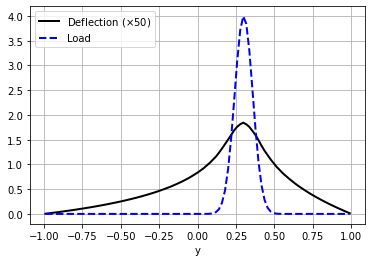

In [14]:
fig = plt.figure()
plt.plot(current_points[:,1], 50*u_values, "k", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(current_points[:, 1], p_values, "b--", linewidth = 2, label="Load")
plt.grid(True)
plt.xlabel("y")
plt.legend()
# If run in parallel as a python file, we save a plot per processor
# plt.savefig(f"membrane_rank{mpi.COMM_WORLD.rank:d}.png")

### Manipulate plot

In [15]:
def smart_plot(x=0):
    tol = 0.01
    y = np.linspace(-1 + tol, 1 - tol, 101)

    view_line = np.zeros((101,3))
    view_line[:,0] = x
    view_line[:,1] = y
    # Collisions:
    geometry_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)

    col_points1 = geometry.compute_collisions(geometry_tree, view_line)
    col_cells1 = geometry.compute_colliding_cells(domain, col_points1,view_line)

    cells = []
    current_points = []

    for i, point in enumerate(view_line):
        if len(col_cells1.links(i)) > 0:
            current_points.append(point)
            cells.append(col_cells1.links(i)[0])
       
    current_points= np.array(current_points,dtype=np.float64)
    u_values= u_func.eval(current_points,cells)
    p_values=p_func.eval(current_points,cells)
    
    fig = plt.figure()
    ax= fig.add_subplot()
    ax.plot(current_points[:,1], 50*u_values, "k", linewidth=2, label="Deflection ($\\times 50$)")
    ax.plot(current_points[:, 1], p_values, "b--", linewidth = 2, label="Load")
    ax.grid(True)
    ax.set_xlabel("y")
    ax.set(xlim=(-1,1),ylim=(0,2))
    ax.legend()
    return 1

In [16]:
x_wdg= wdg.FloatSlider(
    value=0,
    min=0,
    max=1,
    step=0.01,
    description='X: ',
    disabled=False,
    # continuous_update=False,
    # orientation='',
    readout=True,
    # readout_format='d'
)
output = wdg.interactive_output(smart_plot, {'x': x_wdg});
display(x_wdg, output);


FloatSlider(value=0.0, description='X: ', max=1.0, step=0.01)

Output()